# Example 2

**This is adapted from https://github.com/svenreiche/Genesis-1.3-Version4/tree/master/examples/Example2-Dumps**

The internal data of genesis is represented by wavefronts for the fields and the 6D particle distribution for electrons. They contain more information than the output of the main output file.

Genesis supports to export the information to external files, also called dumps.

This example will show the three methods to utilize dumps.

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from genesis.version4 import Genesis4

%config InlineBackend.figure_format = 'retina'  # Nicer plots

## Markers
Markers in the lattice file can trigger the output of either field or particle distribution. To enable outputting the 
lattice file from `Example1.lat` is modified with these lines (replacing the previous definition of the FODO cell of example 1):

```
M: MARKER = {dumpfield = 1};
FODO: LINE={UND,D1,QF,D2,UND,D1,QD,D2,M};
```

Markers are zero length element and do not add to the total length of the lattice. In this case the Marker is added to the end of the FODO cell.
With 6 cells in the full lattice there will be 6 field dumps. They are prefixed with the `rootname` (as in the `setup` namelist) and have the extension 
```.fld.h5```. To differentiate the different outputs the name has also the integration step number in between the `rootname` and the extension. For example, integration step 184 would have the filename ```Example2.184.fld.h5```.

## Dumps Outside of Tracking

The namelist `write` in the main input file can write the field or particle distribution at any point outside of the tracking.
In this example, the input file has the `write` namelist:
```
&write
field = dump
&end
```
This will write the field distribution with the name ```dump.fld.h5```. The extension is included automatically, so you do not specify it in the namelist.

Since Genesis has executed the tracking before, the field distribution represents the state at the end of the tracked beamline. In our case this is the end of the undulator.

## Periodic Output While Tracking

The last method for dumping data is to define in the `track` namelist the number of integration steps after which a dump is issued.
For this example, we modify it to output after every second integration step:

```
&track
beam_dump_step = 2
&end
```
In total about 600 files will be generated with this method, with the filename suffixes including the integration step number.

Note that generating dumps at each step can cause to a large number of files. In particular for time-dependent runs,
the size per dump can be large (on the order of gigabytes) and generating hundreds of them may fill up your disk faster than you expect.


## Running the example

Running ```Example2.in``` causes the additional output when ever a dump file is generated. Also for a better illustraiton of the output, the
energy spread of the beam has been reduced to 
```
delgam=0.100000
```
for a better display of the FEL process.

In [2]:
G = Genesis4("data/example2-dumps/Example2.in")

In [3]:
G.verbose = True
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpyke1mobk
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpyke1mobk
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l Example2.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Wed Jun  5 15:03:04 2024

MPI-Comm Size: 1 node

Opened input file genesis4.in
Parsing lattice file Example2.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 8.53711
   alphax    : -0.703306
   phix (deg): 45.818
   betay (m) : 17.3899
   alphay    : 1.40348
   phiy (deg): 45.818
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing particle distribution to file:

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

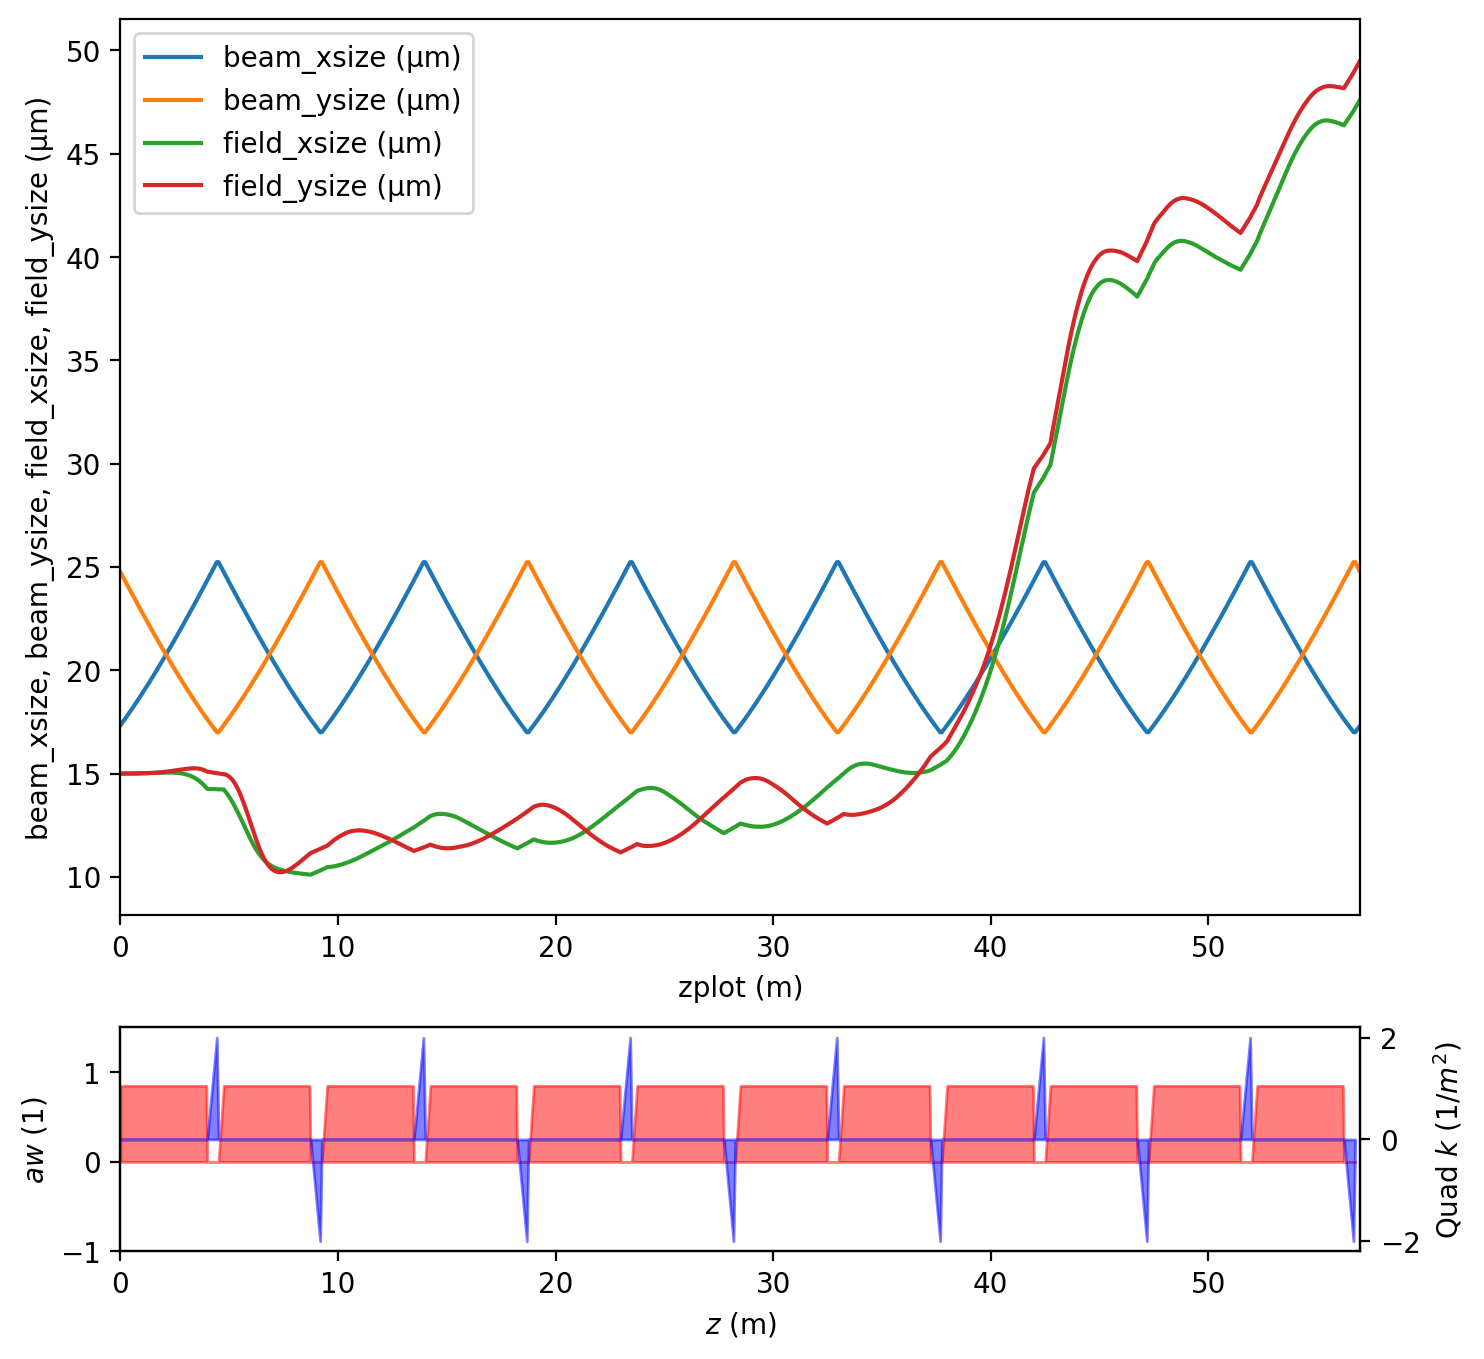

In [4]:
G.plot(["beam_xsize", "beam_ysize", "field_xsize", "field_ysize"], figsize=(8, 8))

In [5]:
print("Loaded fields:", output.load_fields())
print("Total loaded particles files=", len(output.load_particles()))

Loaded fields: ['dump', 184, 368, 552, 736, 920, 1104]
Total loaded particles files= 553


# Wavefront

Wavefront distribution after the first 4 FODO cells. Note that the output seems noisy, which comes from the limited number of macro particles in the simulation and  the reduced diffraction in the Angstrom wavelength regime.

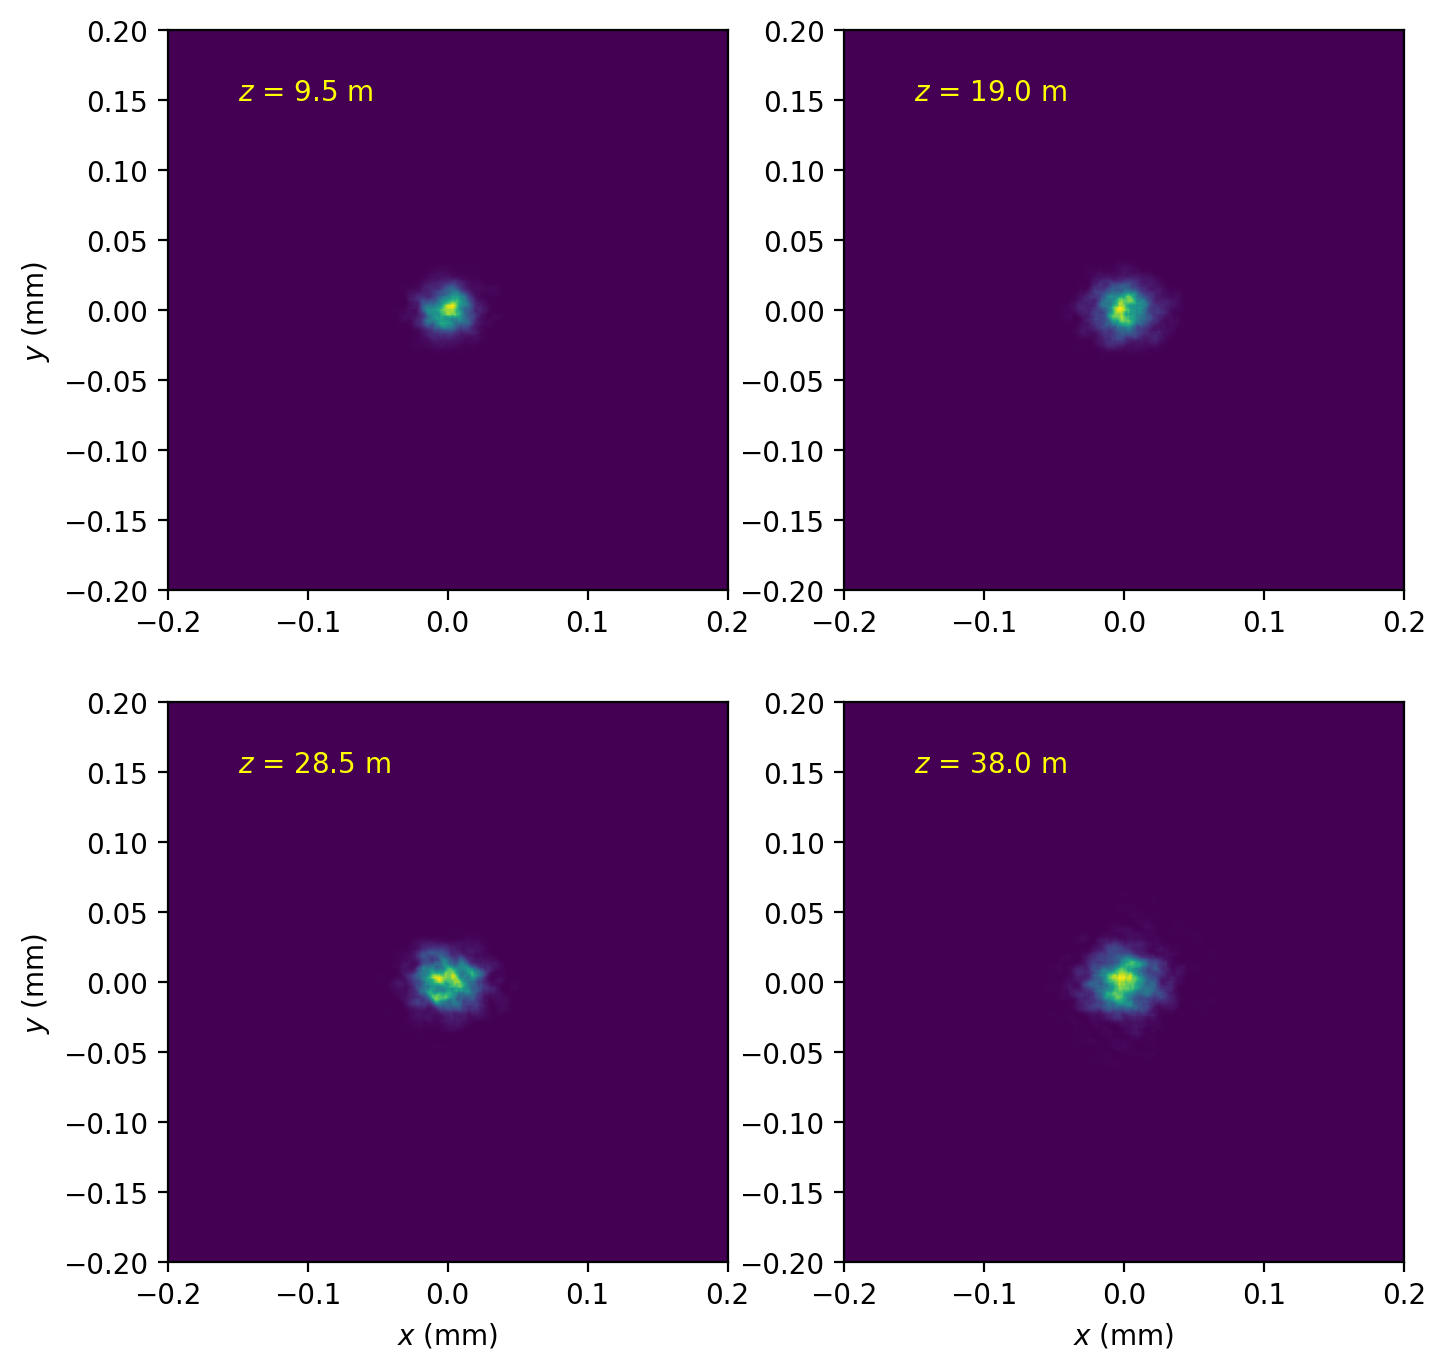

In [6]:
def get_slice(field, slc: int) -> np.ndarray:
    return field.dfl[:, :, slc]


def get_wavefront(field, slice=0):
    # inten = np.reshape(fre * fre + fim * fim, (ng, ng))
    inten = np.abs(get_slice(field, slice) ** 2)
    return inten, field.param.gridsize * (field.param.gridpoints - 1) * 0.5 * 1e3


# plot wavefront
istep = 184
_, axs = plt.subplots(2, 2, figsize=(8, 8))
color = "yellow"
for i1 in range(2):
    for i2 in range(2):
        i = (i2 * 2 + i1 + 1) * istep
        inten, dg = get_wavefront(output.field3d[i], slice=0)
        axs[i2, i1].imshow(inten, extent=(-dg, dg, -dg, dg))
        txt = r"$z$ = %3.1f m" % (9.5 * (i2 * 2 + i1 + 1))
        axs[i2, i1].text(-0.15, 0.15, txt, color=color)

axs[1, 0].set_xlabel(r"$x$ (mm)")
axs[1, 1].set_xlabel(r"$x$ (mm)")
axs[0, 0].set_ylabel(r"$y$ (mm)")
axs[1, 0].set_ylabel(r"$y$ (mm)")
plt.show()

## Longitudinal Phasespace Distribution

This is snapshot of the longitudinal phase space of the electron beam towards the end of the undulator beamline. The x-axis coordinate is the ponderomotive phase, which is given by the longidutinal position multiplied with the wavenumber of the resonant wavelength. In this case, it corresponds to a slice thickness of 1 Angstrom.

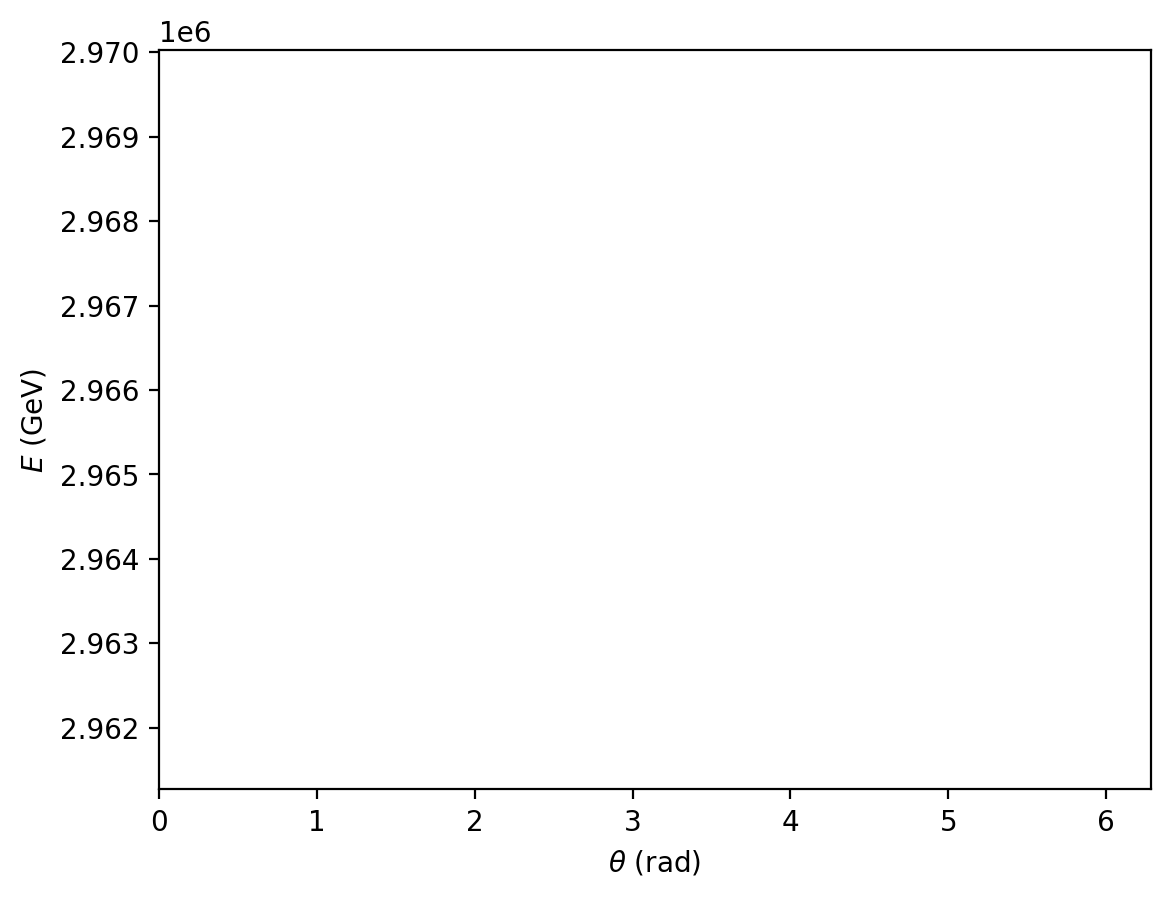

In [7]:
def get_phase_space(particles):
    gamma = particles.gamma * 0.511e-3
    theta = np.mod(particles.theta - np.pi * 0.5, 2 * np.pi)
    return theta, gamma


# get range for phase space plots
emin = np.min(output.beam.emin) * 0.511e-3
emax = np.max(output.beam.emax) * 0.511e-3
xmin = np.min(output.beam.xmin) * 1e6
xmax = np.max(output.beam.xmax) * 1e6

# plot final phase space
t, g = get_phase_space(output.particles[700])
plt.scatter(t, g, s=0.2)
plt.xlabel(r"$\theta$ (rad)")
plt.ylabel(r"$E$ (GeV)")
plt.xlim([0, 2 * np.pi])
plt.ylim([emin, emax])
plt.show()

# Animate phase space

## Animation 1

With the dump of the electron phase space after every second integration step, the python script generates two animation. One for the longitudinal phase space, similar to the plot above.  The other is the distribution in the horizontal plane.

Here the formation of the micro bunching can be seen with its initial modulation in energy to roughly a quarter rotation in phase space. A significant part of electrons are not modulated. These corresponds for electrons with large betatron amplitude, which cannot stay in resonance with the radiation field.

In [8]:
from IPython.display import Video

fig = plt.figure()
ax = plt.axes(xlim=(0, 2 * np.pi), ylim=(emin, emax))
ax.set_xlabel(r"$\theta$ (rad)")
ax.set_ylabel(r"$E$ (GeV)")
scat = ax.scatter([], [], s=0.2)


def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)


def animate(i):
    t, g = get_phase_space(output.particles[2 * i])
    scat.set_offsets(np.hstack((t[:, np.newaxis], g[:, np.newaxis])))
    return (scat,)


# We could also get individual frames by doing the following:
# animate(1)

anim = animation.FuncAnimation(
    fig, animate, init_func=init, blit=False, interval=20, frames=500
)
anim.save("Animation1.mp4")

# Hide our plot and then show the final animation:
plt.close()
Video("Animation1.mp4")

## Animation 2

The breathing in the transverse size comes from the focusing of the FODO lattice. Note that electrons with large amplitude have the tendency to fall backwards quickly. They cannot stay in resonance and thus do not get modulated in energy.

The small jerks in the animation corresponds to the phase shifter, since in the drift there is a phase velocity mismatch between field and beam. To correct that a phase shifter adjust the phase. In Genesis this is done automatically via `autophase`.

In [9]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2 * np.pi), ylim=(xmin, xmax))
ax.set_xlabel(r"$\theta$ (rad)")
ax.set_ylabel(r"$x$ ($\mu$m)")
scat = ax.scatter([], [], s=0.2)


def getTS(particles):
    x = particles.x * 1e6
    theta = particles.theta
    theta = np.mod(theta - np.pi * 0.5, 2 * np.pi)
    return theta, x


def animate2(i):
    t, g = getTS(output.particles[2 * i])
    scat.set_offsets(np.hstack((t[:, np.newaxis], g[:, np.newaxis])))
    return (scat,)


# animate(1)

anim = animation.FuncAnimation(
    fig, animate2, init_func=init, blit=False, interval=20, frames=500
)
anim.save("Animation2.mp4")

# Hide our plot and then show the final animation:
plt.close()
Video("Animation2.mp4")